_Programme: ESTP_   
_Topic: scRNA-seq_  
_Tutor: Elmir Mahammadov_  
_Student: Jafar Isbarov_  
_Paper: Longitudinal single-cell RNA sequencing of patient-derived primary cells reveals drug-induced infidelity in stem cell hierarchy_
# 1. Initial data processing
The pre-porcessed data is presented in two TSV files: `GSE117872_good_Data_TPM.txt` and `GSE117872_good_Data_cellinfo.txt`. I am going to open and convert them into an AnnData object.

In [1]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import pylab as pl
import numpy as np
import louvain
import igraph

import scanpy as sc
import anndata

from sklearn.metrics import adjusted_rand_score, jaccard_score, silhouette_score, adjusted_mutual_info_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

<ipython-input-1-49fb9a78b242>:8: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
with open("GSE117872_good_Data_TPM.txt") as X_data, open("GSE117872_good_Data_cellinfo.txt") as obs_data:
    adata = anndata.read_csv(X_data, delimiter='\t').transpose()
    adata.obs = pd.read_csv(obs_data, sep='\t', index_col=[0])

According to AnnData documentation, variables (genes) have to be the columns and observations (organisms) have to be the rows. Our initial matrix is reversed, so I transposed the resultant AnnData object.

I am going to drop an empty column. I am also going to change values of cluster columns from numeric to categorical (string), so that they will be interpreted as such in data visualization.

In [3]:
adata.obs = adata.obs.drop(columns=['Unnamed: 9'])
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obs['pca_clusters'] = adata.obs['pca_clusters'].astype('category')
adata.obs['pagoda_clusters'] = adata.obs['pagoda_clusters'].astype('category')
adata.obs

,groups,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters
RHC6558,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
RHC6559,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
RHC6560,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
RHC6561,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
RHC6562,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
...,...,...,...,...,...,...,...,...
RHH3298,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
RHH3299,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
RHH3300,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
RHH3301,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3


I also have to log-transform the count matrix, as the range of values is too large.

In [4]:
sc.pp.log1p(adata)
adata.X

array([[0.        , 4.1988926 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.3610713 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.8479787 , 0.        , ..., 0.        , 3.2071471 ,
        0.        ],
       ...,
       [0.        , 3.1489482 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.7155871 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38586873, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

We have 22744 genes to deal with, which is a lot. Not all genes are variable: some of them are expressed equally through the tissue, while others are simply not expressed at all.

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata_3000 = adata[:, adata.var['highly_variable']==True]

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata_2000 = adata[:, adata.var['highly_variable']==True]

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


We are going to work mostly with adata_3000, but we will also use adata_2000 for the sake comparision.

# 2. Dimensionality reduction (with Scanpy)
I am going to use different dimensionality reduction tools and compare the results. All of the dimensionality reduction functions used in this section are from Scanpy.
## 2.1. PCA
At first, I have to figure out the number of necessary PCs. 75 is an appropriate number, as will be explained in section 3.1.

In [6]:
sc.pp.pca(adata_3000, n_comps=75)

## 2.2. UMAP:

In [7]:
sc.pp.neighbors(adata_3000, n_pcs=75)

In [8]:
sc.tl.umap(adata_3000, n_components=75)

## 2.3. tSNE:

In [9]:
sc.tl.tsne(adata_3000, n_pcs=75, use_fast_tsne=True)

## 2.5. Compare
Lastly, we should compare the results of PCA, UMAP, and tSNE algorithms.

... storing 'groups' as categorical
... storing 'cell_color' as categorical
... storing 'patient_id' as categorical
... storing 'origin' as categorical
... storing 'drug_status' as categorical


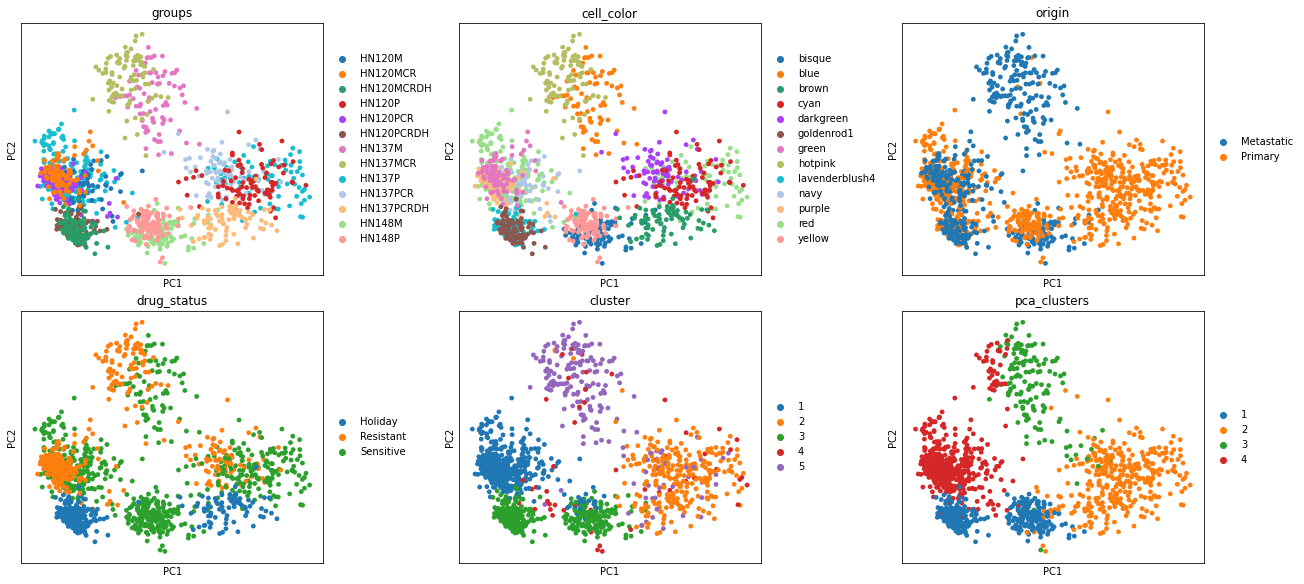

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(18,8),constrained_layout=True)
sc.pl.pca(adata_3000, color='groups', show=False, ax=axs[0][0])
sc.pl.pca(adata_3000, color='cell_color', show=False, ax=axs[0][1])
sc.pl.pca(adata_3000, color='origin', show=False, ax=axs[0][2])
sc.pl.pca(adata_3000, color='drug_status', show=False, ax=axs[1][0])
sc.pl.pca(adata_3000, color='cluster', show=False, ax=axs[1][1])
sc.pl.pca(adata_3000, color='pca_clusters', show=False, ax=axs[1][2])
plt.show()

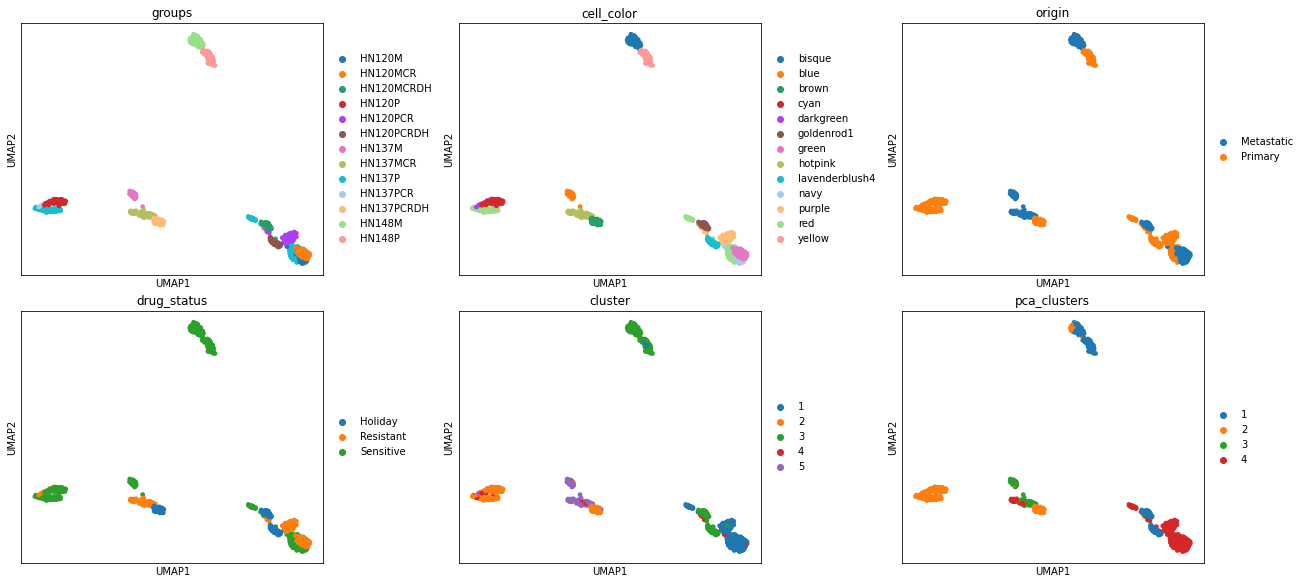

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(18,8),constrained_layout=True)
sc.pl.umap(adata_3000, color='groups', show=False, ax=axs[0][0])
sc.pl.umap(adata_3000, color='cell_color', show=False, ax=axs[0][1])
sc.pl.umap(adata_3000, color='origin', show=False, ax=axs[0][2])
sc.pl.umap(adata_3000, color='drug_status', show=False, ax=axs[1][0])
sc.pl.umap(adata_3000, color='cluster', show=False, ax=axs[1][1])
sc.pl.umap(adata_3000, color='pca_clusters', show=False, ax=axs[1][2])
plt.show()

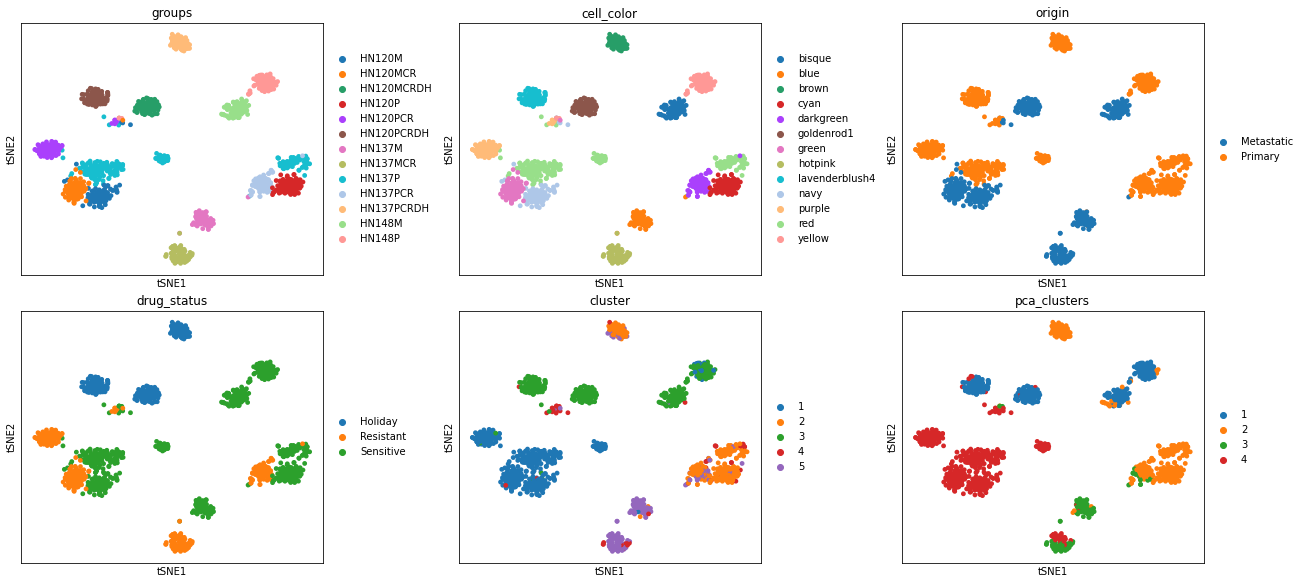

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(18,8),constrained_layout=True)
sc.pl.tsne(adata_3000, color='groups', show=False, ax=axs[0][0])
sc.pl.tsne(adata_3000, color='cell_color', show=False, ax=axs[0][1])
sc.pl.tsne(adata_3000, color='origin', show=False, ax=axs[0][2])
sc.pl.tsne(adata_3000, color='drug_status', show=False, ax=axs[1][0])
sc.pl.tsne(adata_3000, color='cluster', show=False, ax=axs[1][1])
sc.pl.tsne(adata_3000, color='pca_clusters', show=False, ax=axs[1][2])
plt.show()

## 2.6. Cell color vs. groups
Cell color and group clusters seem very similar. We are going to conver these two categorical variables into numerical variables, and then calculate their Adjusted Mutual Score. 

In [13]:
label_encoder = LabelEncoder()
groups = label_encoder.fit_transform(adata.obs['groups'])
cell_color = label_encoder.fit_transform(adata.obs['cell_color'])

In [14]:
adjusted_mutual_info_score(groups, cell_color)

1.0

AMI score is 1.0, which means these two groups are identical.  
  
(This is sufficient, no need for pairwise comparison.)

# 3. Clustering

# 3.1. PCA
Before we do any sort of clustering, we have to perform dimensionality reduction. (We have 20,000+ dimenions at the moment.) I am going to use PCA for this. At first, I have to figure out the number of necessary PCs.  
  
I am also going to perform K-Means clustering on the original data, and compare the results.

In [15]:
pca = PCA().fit(adata_3000.X)

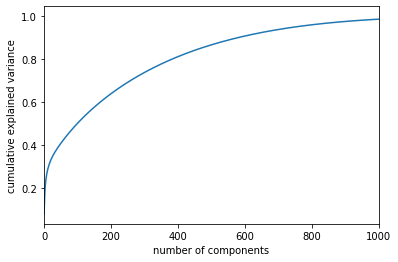

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(0,1000)
plt.show()

We can see that 800 PCs give more than 90% cumulative explained variance. That is good enough for our purpose.

In [17]:
reduced_data = PCA(n_components=800).fit_transform(adata_3000.X)

## 3.2. K-Means clustering
### 3.2.1. Determining K
In this section, I am going to use K-Means Clustering algorithm on the reduced data. At first, we have to find an optimal K.  
[Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) is one way of doing this. I am going to try K-Means algorithm with 40 different K values, and plot their inertia to find the "elbow".

In [ ]:
inertias = []
K = range(1, 200, 10)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced_data)
 
    inertias.append(kmeanModel.inertia_)

In [ ]:
plt.xlabel('K value')
plt.ylabel('inertia')
plt.plot(K, inertias, color='tab:red')
plt.show()

"Elbow" can be said to be around 25. I am going to do the clustering with to different K values: 25 and 5. I will explain my reasoning for the second value below.

### 3.2.2. Performing the clustering

In [18]:
kmeans_pca_5 = KMeans(n_clusters=5).fit(reduced_data)
kmeans_5 = KMeans(n_clusters=5).fit(adata_3000.X)

In [19]:
kmeans_pca_25 = KMeans(n_clusters=25).fit(reduced_data)
kmeans_25 = KMeans(n_clusters=25).fit(adata_3000.X)

In [20]:
def visualize_clusters(kmeans, data, n_clusters, axs, title):
    '''
    A generic function to visualize K-Means clusters created with sklearn
    '''
    for i in range(0, data.shape[0]):
        for j in range(n_clusters):
            if kmeans.labels_[i] == j:
                axs.scatter(data[i,0],data[i,1],s=10)

    axs.set_title(title)

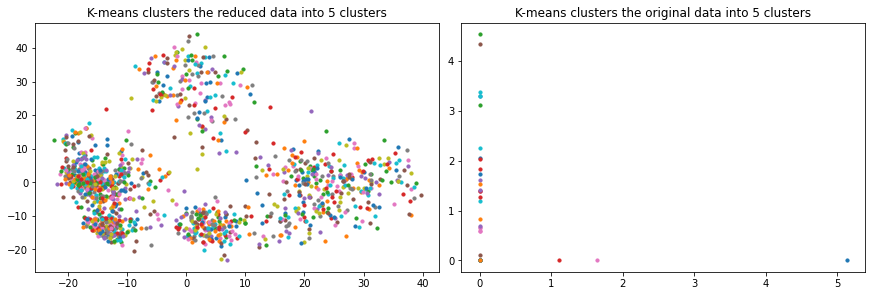

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12,4),constrained_layout=True)
title = 'K-means clusters the reduced data into 5 clusters'
visualize_clusters(kmeans_pca_5, reduced_data, 5, axs[0], title)
title = 'K-means clusters the original data into 5 clusters'
visualize_clusters(kmeans_5, adata_3000.X, 5, axs[1], title)
plt.show()

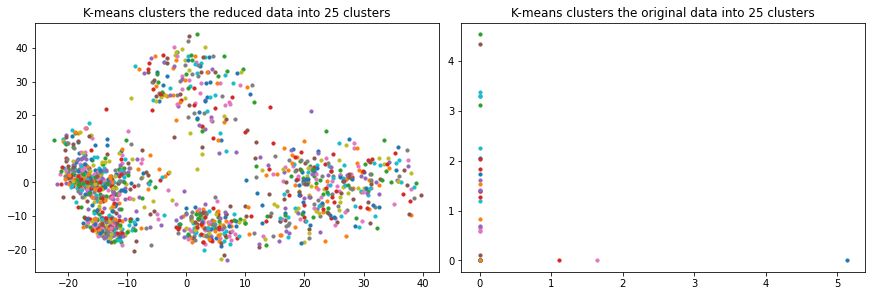

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12,4),constrained_layout=True)
title = 'K-means clusters the reduced data into 25 clusters'
visualize_clusters(kmeans_pca_25, reduced_data, 25, axs[0], title)
title = 'K-means clusters the original data into 25 clusters'
visualize_clusters(kmeans_25, adata_3000.X, 25, axs[1], title)
plt.show()

### 3.2.3. Clustering evaluation
As I have performed K-Means clustering with different K values on the same data, I am interested in comparing the results. There are different methods of evaluating a clustering. All of them requires a set of "true" labels and predicted labels. Some of them are symmetric: "True" and predicted lables can change places without affecting the result. However, we are also going to use non-symmetric metrics. That's why we have to figure out our "true" labels.  
  
I am going to assume the labels of the original data to be "true" and those of the reduced data to be predicted labels. We are going to use several different methods to have a deeper understanding of the clustering performance.

In [23]:
ARI_5 = adjusted_rand_score(kmeans_5.labels_, kmeans_pca_5.labels_)
jaccard_5 = jaccard_score(kmeans_5.labels_, kmeans_pca_5.labels_, average='weighted')
silhouette_5 = silhouette_score(reduced_data, kmeans_pca_5.labels_.reshape(-1, 1))
AMI_5 = adjusted_mutual_info_score(kmeans_5.labels_, kmeans_pca_5.labels_)
CHS_pca_5 = calinski_harabasz_score(adata_3000.X, kmeans_pca_5.labels_)
CHS_5 = calinski_harabasz_score(adata_3000.X, kmeans_5.labels_)

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_5)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_5)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_5)
print('Silhouette Coefficient:          ', '[-1,1]    ', silhouette_5)
print('Calinski-Harabasz Index (PCA):   ', '[-,-]     ', CHS_pca_5)
print('Calinski-Harabasz Index:         ', '[-,-]     ', CHS_5)
print('--------------------------------------------------------')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.9959301418813958
Jaccard Index:                    [0,1]      0.4062980030721966
Adjusted Mutual Information:      [0,1]      0.99334439143846
Silhouette Coefficient:           [-1,1]     0.058910973
Calinski-Harabasz Index (PCA):    [-,-]      63.407961165341845
Calinski-Harabasz Index:          [-,-]      63.403723163237565
--------------------------------------------------------


In [24]:
ARI_25 = adjusted_rand_score(kmeans_25.labels_, kmeans_pca_25.labels_)
jaccard_25 = jaccard_score(kmeans_25.labels_, kmeans_pca_25.labels_, average='weighted')
silhouette_25 = silhouette_score(reduced_data, kmeans_pca_25.labels_.reshape(-1, 1))
AMI_25 = adjusted_mutual_info_score(kmeans_25.labels_, kmeans_pca_25.labels_, average_method='arithmetic')
CHS_pca_25 = calinski_harabasz_score(adata_3000.X, kmeans_pca_25.labels_)
CHS_25 = calinski_harabasz_score(adata_3000.X, kmeans_25.labels_)

print('--------------------------------------------------------')
print('Metric                           ', 'Range     ', 'Result')
print('--------------------------------------------------------')
print('Adjusted Rand Index:             ', '[0,1]     ', ARI_25)
print('Jaccard Index:                   ', '[0,1]     ', jaccard_25)
print('Adjusted Mutual Information:     ', '[0,1]     ', AMI_25)
print('Silhouette Coefficient:          ', '[-1,1]    ', silhouette_25)
print('Calinski-Harabasz Index (PCA):   ', '[-,-]     ', CHS_pca_25)
print('Calinski-Harabasz Index:         ', '[-,-]     ', CHS_25)
print('--------------------------------------------------------')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


--------------------------------------------------------
Metric                            Range      Result
--------------------------------------------------------
Adjusted Rand Index:              [0,1]      0.7309447797408086
Jaccard Index:                    [0,1]      0.12006383659931998
Adjusted Mutual Information:      [0,1]      0.8486010939497689
Silhouette Coefficient:           [-1,1]     0.02817712
Calinski-Harabasz Index (PCA):    [-,-]      18.474306567738655
Calinski-Harabasz Index:          [-,-]      18.40339549490339
--------------------------------------------------------


## 3.3. Leiden and Louvain clustering
There are ready-made Scanpy functions to perform these clusterings. I will initially compare results of Leiden clustering on the original data (~30,000 dimensions) and the reduced data (75 PCs). To do this, we have to find an appropriate resolution.  
  
Calinski-Harabasz Index is _the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)._ Given the formula below:

the modularity should decrease as we increase the resolution, which means Calinski-Harabasz Index and resolution are inversely proportional. Therefore, we need to calculate modularity itself. `scanpy.tl.leiden` does not have a built-in modularity function, so I am going to use `sknetwork.clustering.Louvain` instead.

In [25]:
AMI_leiden = []
AMI_louvain = []
silhouette_louvain = []
silhouette_leiden = []
R = np.arange(0.1, 5, 0.1)
for res in R:
    sc.tl.leiden(adata_3000, resolution = res)
    sc.tl.louvain(adata_3000, resolution = res)
    AMI_leiden.append(adjusted_mutual_info_score(adata_3000.obs['leiden'], adata_3000.obs['groups']))
    AMI_louvain.append(adjusted_mutual_info_score(adata_3000.obs['louvain'], adata_3000.obs['groups']))
    silhouette_louvain.append(silhouette_score(adata_3000.X, adata_3000.obs['louvain']))
    silhouette_leiden.append(silhouette_score(adata_3000.X, adata_3000.obs['leiden']))

In [26]:
R = np.array(R)
AMI_leiden = np.array(AMI_leiden)
AMI_louvain = np.array(AMI_louvain)
silhouette_louvain = np.array(silhouette_louvain)
silhouette_leiden = np.array(silhouette_leiden)

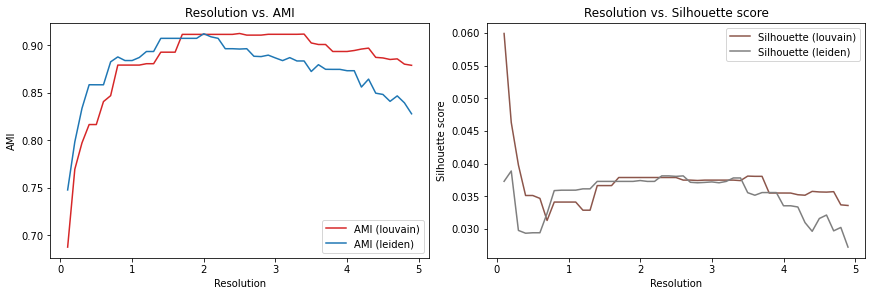

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axs[0].plot(R, AMI_louvain, color='tab:red', label='AMI (louvain)')
axs[0].plot(R, AMI_leiden, color='tab:blue', label='AMI (leiden)')
axs[0].set_xlabel('Resolution')
axs[0].set_ylabel('AMI')
axs[0].set_title('Resolution vs. AMI')
axs[0].legend()

axs[1].plot(R, silhouette_louvain, color='tab:brown', label='Silhouette (louvain)')
axs[1].plot(R, silhouette_leiden, color='tab:grey', label='Silhouette (leiden)')
axs[1].set_xlabel('Resolution')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Resolution vs. Silhouette score')
axs[1].legend()
plt.show()

Resolution=2 will do fine.  

In [28]:
sc.pp.neighbors(adata_3000, n_pcs=75)
sc.tl.leiden(adata_3000, resolution = 2)
sc.tl.louvain(adata_3000, resolution = 2)

Let's use tSNE algorithm to visualize Leiden and Louvain clusterings.

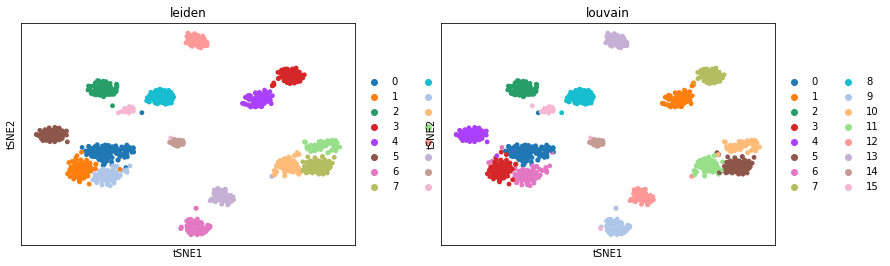

In [29]:
sc.tl.tsne(adata_3000, use_fast_tsne=True)
sc.pl.tsne(adata_3000, color=['leiden', 'louvain'])

We can also compare results of Leiden and Louvain clustering on the same (original) data.

In [30]:
ARI_ll = adjusted_rand_score(adata_3000.obs['leiden'], adata_3000.obs['louvain'])
jaccard_ll = jaccard_score(adata_3000.obs['leiden'], adata_3000.obs['louvain'], average='weighted')
silhouette_leiden = silhouette_score(adata_3000.X, adata_3000.obs['leiden'])
AMI_ll = adjusted_mutual_info_score(adata_3000.obs['leiden'], adata_3000.obs['louvain'])
CHS_leiden = calinski_harabasz_score(adata_3000.X, adata_3000.obs['leiden'])
CHS_louvain = calinski_harabasz_score(adata_3000.X, adata_3000.obs['louvain'])

print('-----------------------------------------------------------------------')
print('Metric:                              ', 'Range     ', 'Result')
print('-----------------------------------------------------------------------')
print('ARI:                                 ', '[0,1]     ', ARI_ll)
print('Jaccard:                             ', '[0,1]     ', jaccard_ll)
print('AMI:                                 ', '[0,1]     ', AMI_ll)
print('Silhouette:                          ', '[-1,1]    ', silhouette_leiden)
print('Calinski-Harabasz (leiden):          ', '[-,-]     ', CHS_leiden)
print('Calinski-Harabasz (louvain):         ', '[-,-]     ', CHS_louvain)
print('-----------------------------------------------------------------------')

-----------------------------------------------------------------------
Metric:                               Range      Result
-----------------------------------------------------------------------
ARI:                                  [0,1]      0.9542208391382918
Jaccard:                              [0,1]      0.2709884183575891
AMI:                                  [0,1]      0.9626012277816254
Silhouette:                           [-1,1]     0.037421294
Calinski-Harabasz (leiden):           [-,-]      27.104235229182702
Calinski-Harabasz (louvain):          [-,-]      27.154019444063636
-----------------------------------------------------------------------


## Detect communities
We can use the `connectivities` info to create an igraph object and detect communities.

In [31]:
adata_graph = igraph.Graph()

In [32]:
#Graph.Adjacency requires int, not float
#works with Weighted)Adjacency
adata_graph.Weighted_Adjacency(adata_3000.obsp['connectivities'])

In [ ]:
#Kills kernel
#partition = louvain.find_partition(adata_graph, louvain.ModularityVertexPartition)

In [ ]:
igraph.plot(adata_graph)

Another comparision can be made among clusterings with different resolution parameters.
# PCA loadings

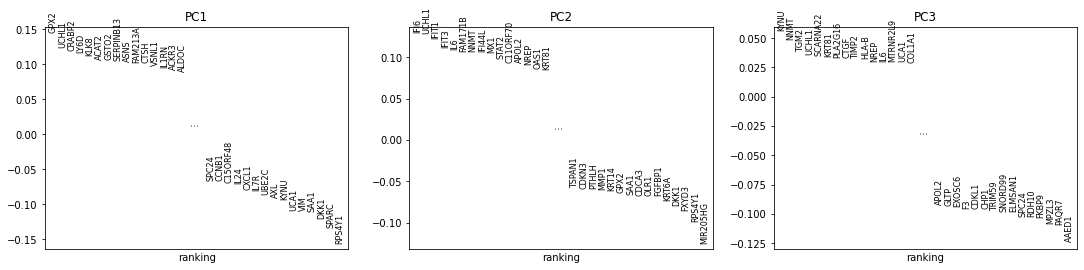

In [33]:
 sc.pl.pca_loadings(adata_3000, components='1,2,3')